# Create Project

In [2]:
#import libraries 
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

# ## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
plt.style.use(('ggplot','tableau-colorblind10'))

In [3]:
## Load in data
FILE = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx"


df = pd.read_excel(FILE, sheet_name='student-mat')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


# Preprocess the data

In [4]:
pd.set_option('display.max_columns',None)
# set the target
y = df['G3']
X = df.drop(columns='G3')

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
215,GP,F,17,U,LE3,T,3,2,other,other,reputation,mother,2,2,0,no,no,yes,no,yes,yes,yes,no,4,4,4,1,3,1,2,14,15
48,GP,M,15,U,GT3,T,4,2,teacher,other,home,mother,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,3,2,2,5,2,15,15
303,GP,F,17,U,GT3,T,3,2,health,health,reputation,father,1,4,0,no,yes,yes,yes,no,yes,yes,no,5,2,2,1,2,5,0,17,17
160,GP,M,17,R,LE3,T,2,1,at_home,other,course,mother,2,1,2,no,no,no,yes,yes,no,yes,yes,3,3,2,2,2,5,0,7,6
60,GP,F,16,R,GT3,T,4,4,health,teacher,other,mother,1,2,0,no,yes,no,yes,yes,yes,no,no,2,4,4,2,3,4,6,10,11


In [5]:
## make pipelines for categorical vs numeric data
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False)
                        )

num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))


## make the preprocessing column transformer with verbose_feature_names_out=False
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002AA199A4250>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002AA199A4130>)],
                  verbose_feature_names_out=False)

In [7]:
#create function
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit-learn-compatible regression model using r-squared and RMSE

    Args:
        model (Regressor): Regression Model with a .predict method
        X_train (DataFrame): Training Features
        y_train (Series): Training Target
        X_test (DataFrame): Test Features
        y_test (Series): Test Target
    """

    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")
    

# Fit Model

## Random Forest

In [8]:
reg = RandomForestRegressor()
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.98	RMSE= 0.66
Test Data:	R^2= 0.91	RMSE= 1.24


# Plot

In [9]:
feature_importance = pd.Series(reg.feature_importances_, index=feature_names,
                        name='Feature Importances')
feature_importance.head()

age           0.015323
Medu          0.004930
Fedu          0.004105
traveltime    0.002238
studytime     0.008951
Name: Feature Importances, dtype: float64

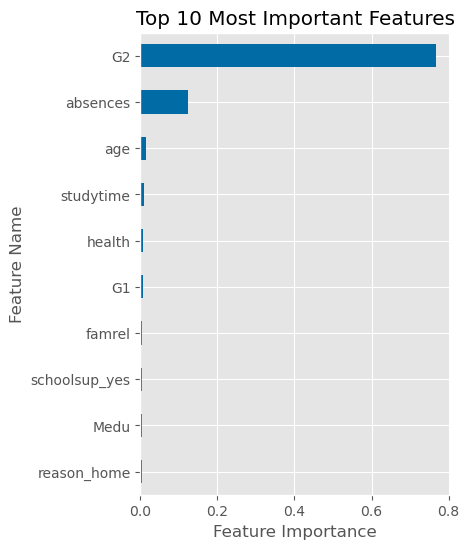

In [10]:
#make plot
ax = feature_importance.sort_values().tail(10).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Feature Importance',
       title='Top 10 Most Important Features');

# Answer Questions

###  The top 5 most important features are:
- G2
- absences
- age
- studytime
- health

### Feature importance
- An "important' feature is one that was used extensively/repeatedly by the model when during the training process. Feature Importance does not indicate directionality.

# Permutation Importance

In [25]:
from sklearn.inspection import permutation_importance

r = permutation_importance(reg, X_train_df, y_train ,n_repeats =5)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [26]:
## can make the mean importances into a series
perm_importances = pd.Series(r['importances_mean'],index=X_train_df.columns,
                           name = 'permutation importance')
perm_importances.head()

age           0.023034
Medu          0.003708
Fedu          0.003007
traveltime    0.001541
studytime     0.009662
Name: permutation importance, dtype: float64

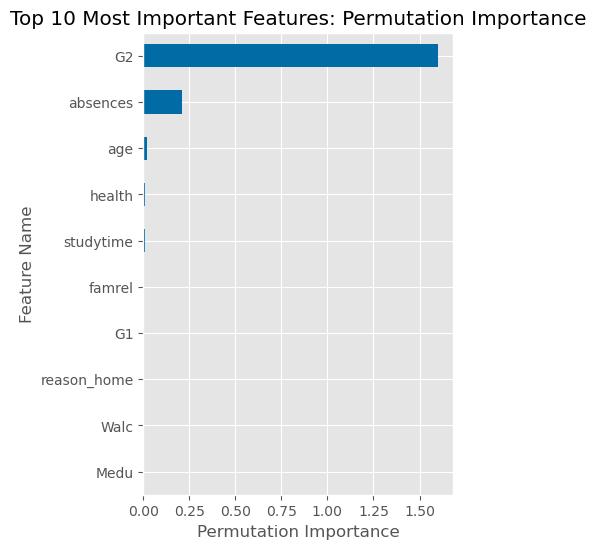

In [27]:
ax = perm_importances.sort_values().tail(10).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Permutation Importance',
       title='Top 10 Most Important Features: Permutation Importance');

###  The top 5 most important features are:

- G2
- absences
- age
- health
- studytime


- Only the order is different

# Linear Regression

In [33]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.85	RMSE= 1.83
Test Data:	R^2= 0.81	RMSE= 1.85


In [34]:
#visualize coeffiients (manually)
coeffs = pd.Series(lin_reg.coef_, index=feature_names,
                        name='Coefficients')
coeffs.loc['intercept'] = lin_reg.intercept_
coeffs.head()

age          -0.220927
Medu          0.291614
Fedu         -0.178924
traveltime    0.187168
studytime    -0.215247
Name: Coefficients, dtype: float64

In [36]:
## rank the coeffs and select the top_n
## rank the coeffs and select the top_n
top_n=15
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
top_n_features = coeff_rank.head(top_n)
coeffs_plot = coeffs.loc[top_n_features.index].sort_values()
coeffs_plot

guardian_father     -5.861081e+11
guardian_mother     -5.861081e+11
guardian_other      -5.861081e+11
reason_home         -2.157239e+11
reason_course       -2.157239e+11
reason_reputation   -2.157239e+11
reason_other        -2.157239e+11
Fjob_services       -1.081995e+11
Fjob_other          -1.081995e+11
Fjob_teacher        -1.081995e+11
Fjob_at_home        -1.081995e+11
Fjob_health         -1.081995e+11
Mjob_teacher        -3.041738e+10
Mjob_at_home        -3.041738e+10
intercept            9.404489e+11
Name: Coefficients, dtype: float64

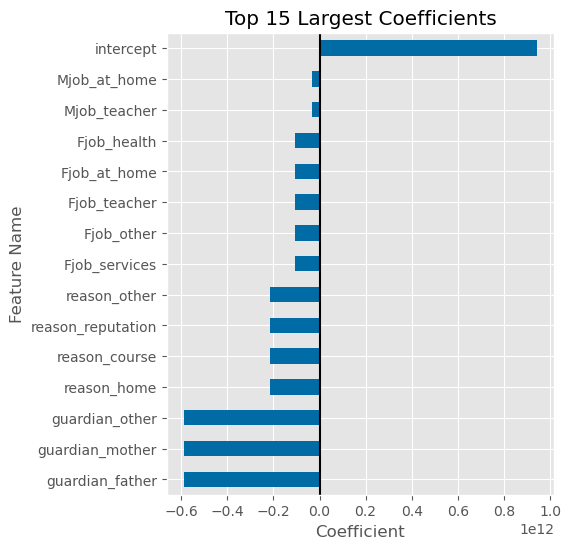

In [31]:
## sort features and keep top_n and set title
ax = coeffs_plot.sort_values().plot(kind='barh',figsize=(5,6))
ax.axvline(0,color='k');
ax.set(title = f"Top {top_n} Largest Coefficients",ylabel="Feature Name",
      xlabel='Coefficient');



## Plot coefficients with function

In [37]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False, 
                annotate=False, ha='left',va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    """Plots the top_n coefficients from a Series, with optional annotations."""
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    
    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                       textcoords=textcoords)
    ## return ax in case want to continue to update/modify figure
    return ax

def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

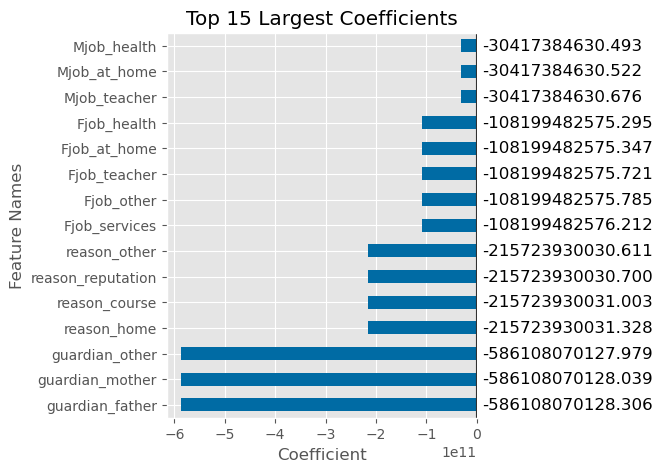

In [38]:
plot_coeffs(coeffs,top_n=15,intercept=False,annotate=True);


### The 3 largest coefficients are for:
- guardian father
- guardian mother
- guardian other